# ***Computer Vision Assignment-3 Solution***

## ***Basic Level***

##### ***Step-1: Importing necessary libraries***

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
import os

##### ***Step-2: Setting up the device either CPU or GPU***

In [2]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Define the transformations for training and testing
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels (RGB)
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels (RGB)
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

Using device: cuda


##### ***Step-3: Loading Caltech-256 Dataset***

In [3]:
train_dataset = datasets.ImageFolder(root="data/256_ObjectCategories", transform=transform_train)
test_dataset = datasets.ImageFolder(root="data/256_ObjectCategories", transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

##### ***Step-4: Train the dataset on ResNet-18 model***

In [4]:

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze the model weights except for the final layer
for param in model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 257)  # 257 classes in Caltech-256

##### ***Step-5***

In [5]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

##### ***Step-6: Training and Evaluating the Model***

In [7]:
# Train and evaluate the model
def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and testing phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluation mode
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader:
                images = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(images)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model


# Fine-tune the model
fine_tuned_model = train_model(model, criterion, optimizer, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.0004 Acc: 1.0000
test Loss: 0.0000 Acc: 1.0000
Epoch 1/4
----------
train Loss: 0.0001 Acc: 1.0000
test Loss: 0.0000 Acc: 1.0000
Epoch 2/4
----------
train Loss: 0.0001 Acc: 1.0000
test Loss: 0.0000 Acc: 1.0000
Epoch 3/4
----------
train Loss: 0.0000 Acc: 1.0000
test Loss: 0.0000 Acc: 1.0000
Epoch 4/4
----------
train Loss: 0.0000 Acc: 1.0000
test Loss: 0.0000 Acc: 1.0000


##### ***Step-7: Model evaluation and Visualization***

In [8]:
# Evaluate the performance of the model before and after fine-tuning
# Function to visualize images and their predictions
def visualize_predictions(model, dataloader, num_images=2):
    model.eval()  # Set the model to evaluation mode
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {preds[i].item()}')
                img = inputs.cpu().data[i]
                img = img.permute(1, 2, 0).numpy()  # Convert from Tensor format
                img = np.clip(img, 0, 1)  # Clip the values for display
                ax.imshow(img)

                if images_so_far == num_images:
                    return

# Function to denormalize the image for visualization
def denormalize(image_tensor):
    # Means and stds used for normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image_tensor.permute(1, 2, 0).numpy()  # Convert tensor to HWC
    image = std * image + mean  # Denormalize
    image = np.clip(image, 0, 1)  # Clip values to be in [0, 1] range
    return image


def make_map_classes(path):
    classes_dir = os.listdir(path)
    classes_dir.sort()
    classes_dict = {}
    for c in classes_dir:
        index = int(c[:3])
        name = c[4:]
        classes_dict[index] = name

    return classes_dict

##### ***Step-8: Comparing Predicted values***

In [11]:
def compare_predictions(pretrained_model, finetuned_model, dataloader, path_dir, num_images=5):
    pretrained_model.eval()
    finetuned_model.eval()

    images_shown = 0
    classes_dict = make_map_classes(path_dir)
    class_keys = list(classes_dict.keys())
    key_offset = 0

    # 🧠 Auto-detect offset: if keys start from 1 but preds start from 0
    if min(class_keys) == 1:
        key_offset = 1

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)

            # Forward passes
            pre_outputs = pretrained_model(inputs)
            _, pre_preds = torch.max(pre_outputs, 1)

            fin_outputs = finetuned_model(inputs)
            _, fin_preds = torch.max(fin_outputs, 1)

            for i in range(inputs.size(0)):
                if images_shown == num_images:
                    return
                images_shown += 1

                img = denormalize(inputs.cpu().data[i])

                plt.figure(figsize=(10, 4))

                # Pre-trained prediction
                plt.subplot(1, 2, 1)
                plt.imshow(img)
                pre_idx = pre_preds[i].item() + key_offset
                plt.title(f'Pre-trained Prediction: {pre_idx} : {classes_dict.get(pre_idx, "Unknown")}')
                plt.axis('off')

                # Fine-tuned prediction
                plt.subplot(1, 2, 2)
                plt.imshow(img)
                fin_idx = fin_preds[i].item() + key_offset
                plt.title(f'Fine-tuned Prediction: {fin_idx} : {classes_dict.get(fin_idx, "Unknown")}')
                plt.axis('off')

                plt.show()


##### ***Step-9: Evaluate and Visualize Predictions***

Comparing predictions of pre-trained and fine-tuned models on example images...


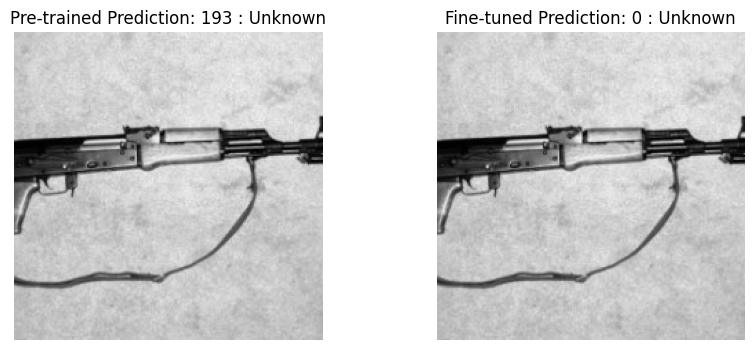

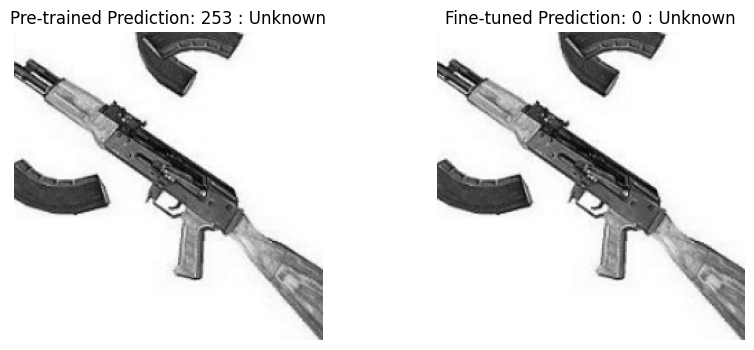

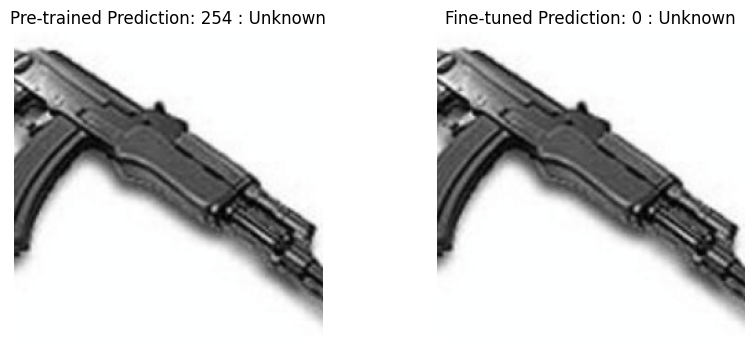

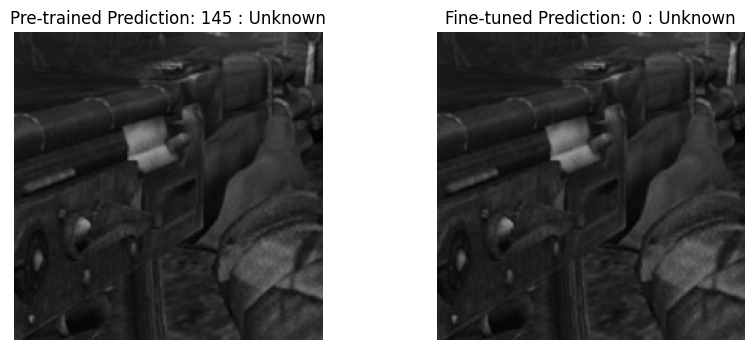

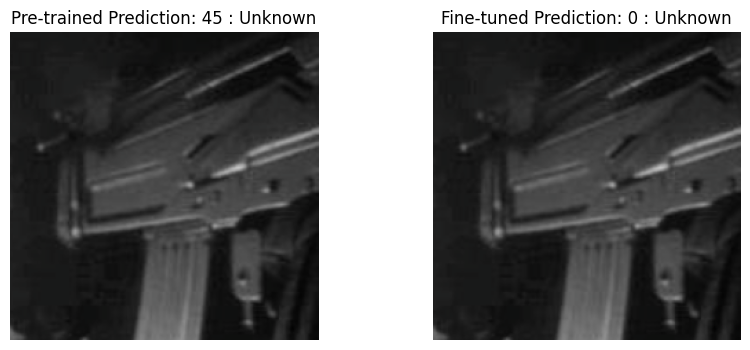

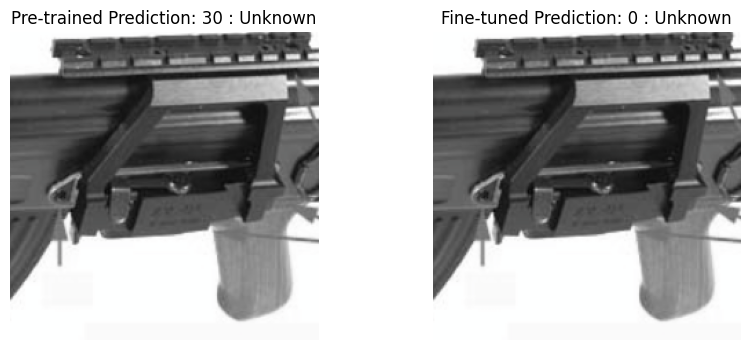

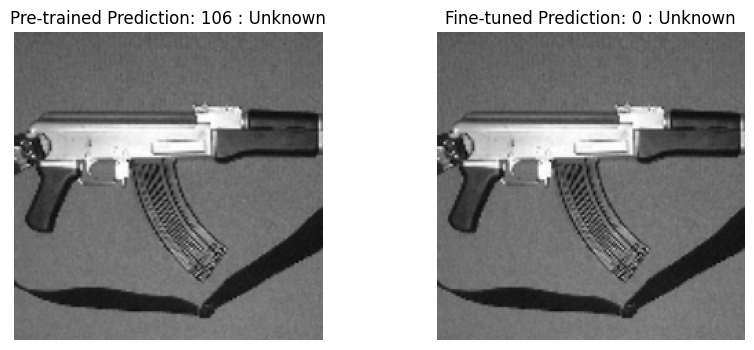

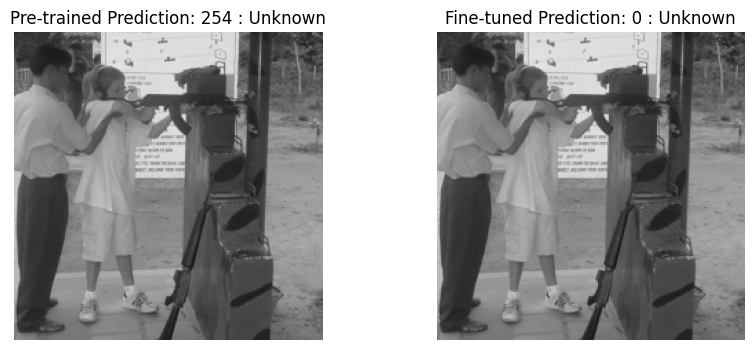

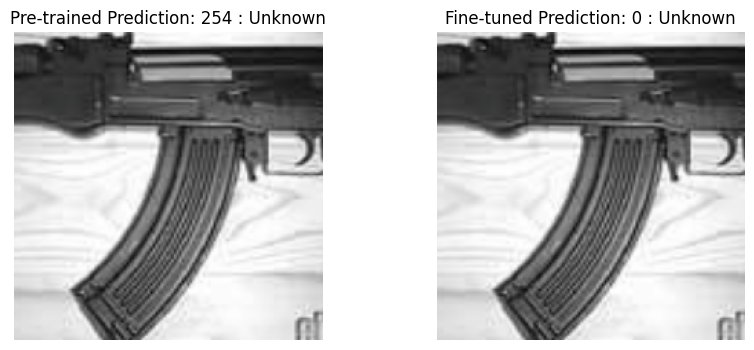

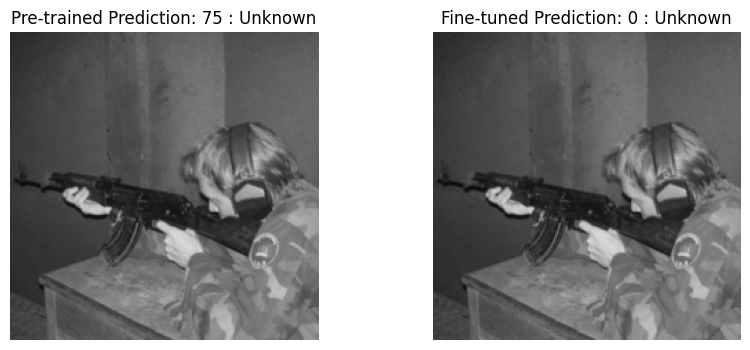

In [12]:
print("Comparing predictions of pre-trained and fine-tuned models on example images...")

# Ensure both models have the same structure (so, freeze layers for pretrained_model)
pretrained_model = models.resnet18(pretrained=True)
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, 257)
pretrained_model = pretrained_model.to(device)

path_to256_ObjectCategories_dir = "data/256_ObjectCategories"
compare_predictions(pretrained_model, fine_tuned_model, test_loader, path_to256_ObjectCategories_dir ,num_images=10)


## ***Advance Level***

##### ***Step-10: Exploring learning rate and Optimization strategies***

In [14]:
# Define a new optimizer (e.g., SGD)
from torch.optim import SGD
new_optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)

# Define a learning rate scheduler (e.g., StepLR)
from torch.optim import lr_scheduler
new_scheduler = lr_scheduler.StepLR(new_optimizer, step_size=7, gamma=0.1)

# Modify the train_model function to include the scheduler
def train_model_with_scheduler(model, criterion, optimizer, scheduler, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and testing phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluation mode
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = torch.tensor(0.0, device=device)

            # Iterate over data
            for inputs, labels in dataloader:
                # Move images and labels to the device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Step the scheduler after each epoch
        scheduler.step()


# Train the model with the new optimizer and scheduler
fine_tuned_model_with_scheduler = train_model_with_scheduler(model, criterion, new_optimizer, new_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.0000 Acc: 0.0000
test Loss: 0.0000 Acc: 0.0000
Epoch 1/4
----------
train Loss: 0.0000 Acc: 0.0000
test Loss: 0.0000 Acc: 0.0000
Epoch 2/4
----------
train Loss: 0.0000 Acc: 0.0000
test Loss: 0.0000 Acc: 0.0000
Epoch 3/4
----------
train Loss: 0.0000 Acc: 0.0000
test Loss: 0.0000 Acc: 0.0000
Epoch 4/4
----------
train Loss: 0.0000 Acc: 0.0000
test Loss: 0.0000 Acc: 0.0000


##### ***Step-11: Investigating Different Freezing Strategies and Layer Unfreezing***

In [20]:
# Unfreeze the last few layers (e.g., layer4 and the fully connected layer)
def unfreeze_last_layers(model, num_layers_to_unfreeze=2):
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the fully connected layer (already unfrozen in Step 4, but good to be explicit)
    for param in model.fc.parameters():
        param.requires_grad = True
    
    unfrozen_layers = [model.layer4, model.layer3, model.layer2, model.layer1]

    for i in range(min(num_layers_to_unfreeze, len(unfrozen_layers))):
        for param in unfrozen_layers[i].parameters():
            param.requires_grad = True
    
    print(f"✅ Unfroze last {num_layers_to_unfreeze} layers (and fc).")

    trainable = [name for name, p in model.named_parameters() if p.requires_grad]
    print(f"Trainable parameters ({len(trainable)}):")
    for n in trainable:
        print("  ", n)

# Unfreeze all layers (use with caution, especially on small datasets)
def unfreeze_all_layers(model):
    for param in model.parameters():
        param.requires_grad = True

def train_model_with_scheduler(model, criterion, optimizer, scheduler, dataloaders, num_epochs=5, device='cuda'):
    model.to(device)
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)

            print(f"{phase} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

            if phase == 'train':
                scheduler.step()

    print("\n✅ Training complete.")
    return model

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 257)  # For 257 classes
model = model.to(device)
criterion = nn.CrossEntropyLoss()
dataloaders = {'train': train_loader, 'val': test_loader}

unfreeze_last_layers(model, num_layers_to_unfreeze=2)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

fine_tuned_model = train_model_with_scheduler(model, criterion, optimizer, scheduler, dataloaders, 5, device)


    

# Example usage:
# Assuming 'model' is the pretrained ResNet-18 loaded in Step 4
# First, freeze all layers as in Step 4
# for param in model.parameters():
#     param.requires_grad = False

# Then, choose a strategy:
# unfreeze_last_layers(model, num_layers_to_unfreeze=2) # Unfreeze layer4 and layer3
# OR
# unfreeze_all_layers(model) # Unfreeze all layers

# After unfreezing, you would re-define your optimizer to include the newly unfrozen layers
# new_optimizer_for_unfrozen = optim.Adam(model.parameters(), lr=0.0001) # Lower learning rate is often recommended
# Then train the model again with the new optimizer
# fine_tuned_model_unfrozen = train_model(model, criterion, new_optimizer_for_unfrozen, num_epochs=5)

# You would then evaluate and compare this model's performance as done in Step 9.
# Train and Evaluate the new model on the previously given dataset.

✅ Unfroze last 2 layers (and fc).
Trainable parameters (32):
   layer3.0.conv1.weight
   layer3.0.bn1.weight
   layer3.0.bn1.bias
   layer3.0.conv2.weight
   layer3.0.bn2.weight
   layer3.0.bn2.bias
   layer3.0.downsample.0.weight
   layer3.0.downsample.1.weight
   layer3.0.downsample.1.bias
   layer3.1.conv1.weight
   layer3.1.bn1.weight
   layer3.1.bn1.bias
   layer3.1.conv2.weight
   layer3.1.bn2.weight
   layer3.1.bn2.bias
   layer4.0.conv1.weight
   layer4.0.bn1.weight
   layer4.0.bn1.bias
   layer4.0.conv2.weight
   layer4.0.bn2.weight
   layer4.0.bn2.bias
   layer4.0.downsample.0.weight
   layer4.0.downsample.1.weight
   layer4.0.downsample.1.bias
   layer4.1.conv1.weight
   layer4.1.bn1.weight
   layer4.1.bn1.bias
   layer4.1.conv2.weight
   layer4.1.bn2.weight
   layer4.1.bn2.bias
   fc.weight
   fc.bias

Epoch 1/5
------------------------------
train Loss: 0.2147  Acc: 0.9755
val Loss: 0.0020  Acc: 1.0000

Epoch 2/5
------------------------------
train Loss: 0.0011  Acc: 1.00

##### ***Evaluatory Task***

In [ ]:
def unfreeze_last_layers(model, num_layers_to_unfreeze=2):
    # Unfreeze the fully connected layer
    for param in model.fc.parameters():
        param.requires_grad = True

    # Unfreeze the last 'num_layers_to_unfreeze' convolutional layers
    unfrozen_layers = [model.layer4, model.layer3]
    for i in range(min(num_layers_to_unfreeze, len(unfrozen_layers))):
        for param in unfrozen_layers[i].parameters():
            param.requires_grad = True

def unfreeze_all_layers(model):
    for param in model.parameters():
        param.requires_grad = True


def train_model_with_scheduler(model, criterion, optimizer, scheduler, dataloaders, num_epochs=5, device='cuda'):
    since = time.time()
    model = model.to(device)

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print('-' * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                scheduler.step()

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last few layers (experiment here)
unfreeze_last_layers(model, num_layers_to_unfreeze=2)

# Modify final classification layer for Caltech-256
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 257)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

dataloaders = {
    'train': train_loader,
    'val': test_loader
}

fine_tuned_model_advanced = train_model_with_scheduler(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    dataloaders=dataloaders,
    num_epochs=5,
    device=device
)

print("\nEvaluating model visually...")
visualize_predictions(fine_tuned_model_advanced, test_loader, path_to256_ObjectCategories_dir, num_images=5)
compare_predictions(pretrained_model, fine_tuned_model_advanced, test_loader, path_to256_ObjectCategories_dir, num_images=5)